# Import Libraries

In [1]:
# Run in python console
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim (Topic Modeling Pacakge)
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

# spacy for lemmatization
import spacy
from spacy.lang.en.examples import sentences 
spacy.cli.download("en_core_web_sm")

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim # don't skip this
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
nltk.download('words')
words = set(nltk.corpus.words.words())

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to /Users/sonia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/sonia/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
stop_new = ['mrt', 'station', 'see', 'bus', 'buses', 'line', 'account', 'one', 'full',
                     'get', 'min', 'class', 'year', 'pm', '', 'take', 'taxi', 'allow', 'last', 'almost',
                     'post', 'start', 'cross', 'car_rental', 'comfortdelgro', 'singapore', 'grab',
                     'night', 'find', 'need', 'build', 'photo', 'video', 'leave', 'car', 'train', 
                     'think', 'food', 'make', 'set', 'fresh', 'sbs', 'driver', 'delgro', 'comfort',  
                     'move',  'ever', 'blue', 'uber', 'go', 'look', 'use', 'also', 'give', 
                     'many', 'come', 'lot', 'seem', 'guess', 'definitely', 'sure', 'keep', 'much', 'already', 
                     'do', 'lol', 'people', 'well', 'back', 'week', 'u', 'want', 'day', 'will', 'know', 
                     'even', 'really', 'said', 'say', 'cab', 'public transport', 'taxis', 'public', 
                     'transport', 'thing', 'still', 'got', 'now', 's', 'stop', 'around', 'another', 
                     'smrt', 'next', 'us', 'may', 'person', 'years', 'going', 'trains', 'way', 
                     'seat', 'guy', 'https', 'always', 'riders', 'cabbie', 'sg', 'drivers', 'auntie', 'man', 
                     'uncle', 'stops', 'someone', 'something', 'andy', 'cabs', 'cabbies', 'order', 'delivery', 
                     'gojek', 'quite','fucking', 'every', 'getting', 'trying', 'told', 'something', 'singaporean', 
                     'feel', 'lta', 'fuck', 'without', 'let', 'made', 'getting', 'passenger', 'restaurant', 'grabfood', 
                     'merchant', 'don', 't', 'customer', 'cars', 'actually', 'senior', 'entrepreneur', 'rental', 'cars', 'current']

stop_words.extend(stop_new)

# Import DataFrame

In [36]:
df_csisg_2015_to_2019  = pd.read_csv('../../../Data/CSISG/Text Data/2015_2019_filtered_planning_area_text_clean.csv', encoding='utf-8')
df_csisg_2020 = pd.read_csv('../../../Data/CSISG/Text Data/2020 CSISG Land Transport Text Data filtered.csv', encoding='utf-8')
df_survey =  pd.read_excel('../../../Data/Survey/raw_survey_data_402.xlsx')
df_reddit_before = pd.read_csv('../../../Data/Scrapping/Reddit/sentiment/df_clean_cat_bcovid_sent.csv')
df_reddit_after = pd.read_csv('../../../Data/Scrapping/Reddit/sentiment/df_clean_cat_acovid_sent.csv')

In [37]:
df_csisg_2015_to_2019.head()

,uid,year,sub_sector_verbatim,weight_of_market_share,customer_expectations_score,perceived_overall_quality_score,perceived_value_score,customer_satisfaction_score,customer_loyalty‎_user_trust_score,trains_sufficient_train_arrival_info,...,bookingapp_accuracy_of_time_estimate,bookingapp_app_promotions,bookingapp_ease_of_getting_ride,app_with_fares_charged,education,gender,housetype,postal_code,verbatim_reasons,planning_area
0,93,2019,MRT/LRT,0.038336,66.144710,81.386766,83.840623,70.822366,70.135632,9,...,,,,,7,2,4,670177,"THEY MAINTAINED THE TRAINS AND STATIONS WELL, ...",BUKIT PANJANG
1,154,2019,MRT/LRT,0.187418,70.727360,62.339718,61.618400,58.830962,67.118773,8,...,,,,,5,2,3,542325,SELF HELP TOP MACHINE IS VERY USER FRIENDLY,SENGKANG
2,157,2019,Public Buses,1.000239,62.605974,70.058748,82.826044,59.711255,83.559386,,...,,,,,7,1,3,542325,THE BUSES ARE CLEAN AND WELL MAINTAINED,SENGKANG
3,186,2019,Public Buses,1.594724,58.819786,78.495738,83.840623,67.142361,74.098572,,...,,,,,7,2,3,542267,NaN,SENGKANG
4,222,2019,MRT/LRT,0.187418,70.452854,59.665597,72.729511,59.235561,62.388366,7,...,,,,,7,1,4,543121,"WAITING TIME IS SHORT, ACCURATE ARRIVAL TIMING...",SENGKANG


In [38]:
df_csisg_2020.head()

,uid,year_of_survey,sub-sector_code,weights_to_account_for_market_share,customer_expectations_score,perceived_overall_quality_score,perceived_value_score,customer_satisfaction_score,customer_loyalty‎/_user_trust_score,trains_sufficient_train_arrival_info,...,point-to-point_transport_ease_of_providing_feedback,point-to-point_transport_ease_of_using_app,point-to-point_transport_accuracy_of_waiting_time_estimation,point-to-point_transport_attractiveness_of_app_promotions_and_discounts,education_qualification,gender,housetype_according_to_respondent,postal_code,verbatim:_reasons_for_their_satisfaction_ratingss,verbatim:_suggested_areas_of_improvement
0,204397,2020,Public Buses,1.091275,92.861895,100.000000,77.777778,92.901742,82.234797,,...,,,,,7,2,4,67,they always greet me good morning and have smi...,"because 972 is a big double decker bus, when i..."
1,208980,2020,Public Buses,0.919861,74.554122,80.834136,78.422920,74.035977,70.106001,,...,,,,,8,2,3,56,Overall ride was positive,Frequency
2,204211,2020,Public Buses,1.091275,96.026993,82.386659,77.777778,85.068707,69.401450,,...,,,,,5,1,4,73,Reliable and fast,NOthing
3,201828,2020,Public Buses,1.091275,77.777778,66.666667,66.666667,77.777778,78.560612,,...,,,,,8,2,3,56,Its pleasant enough,hygiene of the bus
4,203670,2020,Public Buses,1.091275,81.001434,66.666667,83.655904,77.777778,71.515103,,...,,,,,8,2,3,68,Inaccurate bus arrival timing Frequency and ...,Punctuality and frequency


In [39]:
df_survey.head()

,Unnamed: 0,ID,Start time,Completion time,Email,Name,What is your age?,What is your gender?,What is your current employment status?,What is your monthly income range?,...,cost_cdg,comfort_cdg,reliability_cdg,info_cdg,overall_rating_cdg,perception_cdg,improvement_cdg,incentives_cdg,aware_cdg_cnt,used_cdg_cnt
0,0,4,9/1/21 0:38:08,9/1/21 0:48:28,anonymous,NaN,22 - 25,Female,Full-time Student;,Below $500,...,Somewhat dissatisfied,Somewhat satisfied,Somewhat satisfied,Neutral,Neutral,Just a taxi company,Not very sure don’t take them often,"['More locations to rent from', 'Competitive p...",1,1
1,1,5,9/1/21 0:44:47,9/1/21 1:01:51,anonymous,NaN,22 - 25,Female,Employed Part-time;Full-time Student;,Below $500,...,Somewhat dissatisfied,Somewhat satisfied,Somewhat satisfied,Somewhat satisfied,Neutral,NaN,NaN,"['More locations to rent from', 'Competitive p...",1,1
2,2,12,9/1/21 9:55:31,9/1/21 10:06:14,anonymous,NaN,22 - 25,Male,Full-time Student;,Below $500,...,Neutral,Somewhat satisfied,Very satisfied,Somewhat satisfied,Somewhat satisfied,Rides are really comfy,Lowering their price to compete with grab/gojek,"['More locations to rent from', 'Promotion cod...",1,1
3,3,13,9/1/21 10:01:29,9/1/21 10:06:21,anonymous,NaN,18 - 21,Female,Full-time Student;,Below $500,...,Somewhat satisfied,Somewhat satisfied,Somewhat satisfied,Somewhat satisfied,Somewhat satisfied,NaN,NaN,['Competitive prices'],1,1
4,4,14,9/1/21 10:00:35,9/1/21 10:06:31,anonymous,NaN,22 - 25,Female,Contract;,Prefer not to say,...,Neutral,Neutral,Neutral,Neutral,Neutral,NaN,NaN,[''],1,1


In [40]:
df_reddit_before.head()

,text,author,date,score,category,sentiment
0,i understand some people here seem to miss the...,['c8jogr'],03/07/2019,1218,taxi,Positive
1,"so on my way back home, my taxi broke down, i ...",['btvmeg'],28/05/2019,1151,taxi,Negative
2,taxi touting at ion orchard,['a9t97u'],27/12/2018,502,taxi,Neutral
3,23yo edgelord throws $1000 in taxi driver's fa...,['8cfad6'],15/04/2018,399,taxi,Neutral
4,"kathy was a ‘people person’, loved by many: fa...",['8dwlb2'],21/04/2018,357,taxi,Positive


In [41]:
df_reddit_after.head()

,text,author,date,score,category,sentiment
0,a old photo of crown taxis stacked up against ...,['nylm3e'],13/06/2021,2070,taxi,Positive
1,new cabinet announcement,['orhpisai1990'],26/07/2020,839,taxi,Positive
2,taxi as wedding car,['mur287'],20/04/2021,838,taxi,Neutral
3,taxi driver's armpit sweat output 1000%,['jodnvv'],05/11/2020,678,taxi,Neutral
4,"in 1997,toyota’s crown comfort was bought as t...",['hlfv2x'],05/07/2020,519,taxi,Positive


In [42]:
#selecting text columns only
df_reddit_after_text = df_reddit_after['text']
df_reddit_before_text = df_reddit_after['text']
df_csisg_2020_text = df_csisg_2020[["verbatim:_reasons_for_their_satisfaction_ratingss","verbatim:_suggested_areas_of_improvement"]]
df_csisg_2015_to_2019_text = df_csisg_2015_to_2019['verbatim_reasons']

In [43]:
df_csisg_2020_text.head()

,verbatim:_reasons_for_their_satisfaction_ratingss,verbatim:_suggested_areas_of_improvement
0,they always greet me good morning and have smi...,"because 972 is a big double decker bus, when i..."
1,Overall ride was positive,Frequency
2,Reliable and fast,NOthing
3,Its pleasant enough,hygiene of the bus
4,Inaccurate bus arrival timing Frequency and ...,Punctuality and frequency


In [44]:
df_csisg_2015_to_2019_text.head()

0    THEY MAINTAINED THE TRAINS AND STATIONS WELL, ...
1          SELF HELP TOP MACHINE IS VERY USER FRIENDLY
2              THE BUSES ARE CLEAN AND WELL MAINTAINED
3                                                  NaN
4    WAITING TIME IS SHORT, ACCURATE ARRIVAL TIMING...
Name: verbatim_reasons, dtype: object

In [45]:
#selecting text columns only
df_survey_text = df_survey[["Based off your ranking choices above, why do you prefer not to take the last 2 least preferred mode of transport?",
            "Under what circumstances will you take your last 2 least preferred mode of transport?",
            "On what occasion would you charter a bus?",
            "Do you ever experienced difficulties finding a ride? Can you briefly describe when and where? (E.g. MRT breakdown, Raffles)",
            "Why do you prefer these ride-hailing services?",
            "Do you ever experienced difficulties finding a ride? Can you briefly describe when and where? (E.g. MRT breakdown, Raffles)2",
            "If Yes, please briefly describe the problem.",
            "If No, what are the difficulties that you've faced? Are there any locations where you think that it should be catered for?",
            "What are your perceptions of the companies that you've selected above?",
            "What are your opinions on ComfortDelGro?",
            "How do you think ComfortDelGro can improve their services?"
                 ]]

In [46]:
df_survey_text.head()

,"Based off your ranking choices above, why do you prefer not to take the last 2 least preferred mode of transport?",Under what circumstances will you take your last 2 least preferred mode of transport?,On what occasion would you charter a bus?,"Do you ever experienced difficulties finding a ride? Can you briefly describe when and where? (E.g. MRT breakdown, Raffles)",Why do you prefer these ride-hailing services?,"Do you ever experienced difficulties finding a ride? Can you briefly describe when and where? (E.g. MRT breakdown, Raffles)2","If Yes, please briefly describe the problem.","If No, what are the difficulties that you've faced? Are there any locations where you think that it should be catered for?",What are your perceptions of the companies that you've selected above?,What are your opinions on ComfortDelGro?,How do you think ComfortDelGro can improve their services?
0,Expensive to rent a car. Singapore too hot to ...,When there is no choice,NaN,Yes when it is late at night. From SMU back to...,"Familiar with the software, easy user interface",Nil,NaN,NaN,NaN,Just a taxi company,Not very sure don’t take them often
1,Car Rentals are expensive. Destination too far...,If it's nearby or if car rentals are the cheap...,Going on a trip to somewhere with many people ...,"Peak hours, CBD or secluded areas",More affordable and competitive pricing.,"Peak hours, CBD and secluded areas",NaN,Near Shopping Malls or MRT stations or Estates...,NaN,NaN,NaN
2,The price point,In dire situation where I can’t get grab/gojek...,NaN,NaN,Because of ongoing promotions,NaN,NaN,NaN,NaN,Rides are really comfy,Lowering their price to compete with grab/gojek
3,Expensive,Running late,NaN,NIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
#merging df
df = pd.concat([df_reddit_before_text,df_reddit_after_text,df_csisg_2020_text,df_csisg_2015_to_2019_text,df_survey_text])

In [48]:
df = df[0]

In [49]:
df.head()

0    a old photo of crown taxis stacked up against ...
1                             new cabinet announcement
2                                  taxi as wedding car
3              taxi driver's armpit sweat output 1000%
4    in 1997,toyota’s crown comfort was bought as t...
Name: 0, dtype: object

# Prepare DataFrame for Topic Modelling

# Tokenize Each Sentence

Create Function

In [51]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

Execute Function

In [52]:
df_data_words = list(sent_to_words(df))


# Build Bigram and Trigram Models

## Overall

In [53]:
# Build the bigram and trigram models
df_data_bigram = gensim.models.Phrases(df_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
df_data_trigram = gensim.models.Phrases(df_data_bigram[df_data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
df_data_bigram_mod = gensim.models.phrases.Phraser(df_data_bigram)
df_data_trigram_mod = gensim.models.phrases.Phraser(df_data_trigram)

# See trigram example
#print(overall_acovid_title_data_trigram_mod[overall_acovid_title_data_bigram_mod])
print(df_data_trigram_mod[df_data_bigram_mod[df_data_words[1]]])

['new', 'cabinet', 'announcement']


# Define Functions

In [54]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts, trigram_mod, bigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Call the Functions

## Overall

In [55]:
# Remove Stop Words
df_data_words_nostops = remove_stopwords(df_data_words)

# Form Bigrams
df_data_words_bigrams = make_bigrams(df_data_words_nostops, df_data_bigram_mod)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
df_data_lemmatized = lemmatization(df_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(df_data_lemmatized[:1])

[['old', 'crown', 'stack', 'scrap']]


# Creating the two main inputs to the LDA topic model: the dictionary(id2word) and the corpus.

## Overall

In [56]:
# Create Dictionary
df_data_id2word = corpora.Dictionary(df_data_lemmatized)

# Create Corpus
df_data_texts = df_data_lemmatized

# Term Document Frequency
df_data_corpus = [df_data_id2word.doc2bow(text) for text in df_data_texts]

# View
print(df_data_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


# Build the Topic Model

In [57]:
# Build LDA model
def lda_model(corpus, id2word, n_topics):

    model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    return model

In [ ]:
df_data_ldamodel = lda_model(df_data_corpus, df_data_id2word, 9)

In [70]:
df_data_doc_lda = df_data_ldamodel[df_data_corpus]

# Calculate Model Perplexity and Topic Coherence

## Overall

In [71]:
# Compute Perplexity
print('\nPerplexity: ', df_data_ldamodel.log_perplexity(df_data_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
df_data_coherence_model_lda = CoherenceModel(model=df_data_ldamodel, texts=df_data_lemmatized, dictionary=df_data_id2word, coherence='c_v')
df_data_coherence_lda = df_data_coherence_model_lda.get_coherence()
print('\nCoherence Score: ', df_data_coherence_lda)



Perplexity:  -9.035323415995459

Coherence Score:  0.2975469190448593


In [61]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

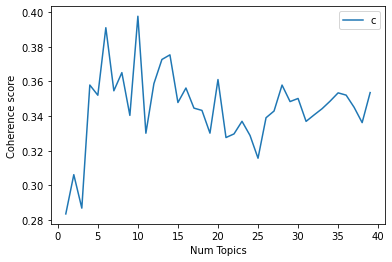

In [62]:
model_list, coherence_values = compute_coherence_values(dictionary=df_data_id2word,
                                                        corpus=df_data_corpus,
                                                        texts=df_data_lemmatized,
                                                        start=1, limit=40, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=1; step=1;

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

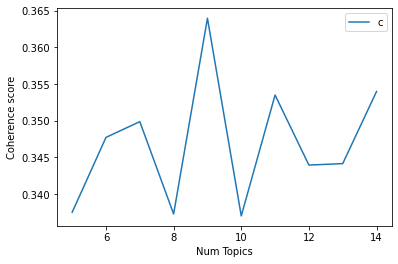

In [64]:
model_list, coherence_values = compute_coherence_values(dictionary=df_data_id2word,
                                                        corpus=df_data_corpus,
                                                        texts=df_data_lemmatized,
                                                        start=5, limit=15, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=15; start=5; step=1;

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Visualize the topics

## Overall

In [72]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(df_data_ldamodel,
                              df_data_corpus, 
                              df_data_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.369439 -0.096386       1        1  24.009899
5      0.042601 -0.145728       2        1  15.860216
2     -0.069569  0.331789       3        1  11.469934
3      0.053628  0.011263       4        1  11.234582
7      0.074190 -0.022586       5        1  10.280560
1      0.064456 -0.024223       6        1   8.475704
8      0.068548 -0.020877       7        1   8.014799
0      0.067826 -0.016565       8        1   5.449722
4      0.067760 -0.016686       9        1   5.204583, topic_info=               Term         Freq        Total Category  logprob  loglift
91             time  5137.000000  5137.000000  Default  30.0000  30.0000
1257           fast  3957.000000  3957.000000  Default  29.0000  29.0000
79          service  3067.000000  3067.000000  Default  28.0000  28.0000
92           travel  4226.000000  4226.000000  Default  27.0000  27.0000
2205    comfortable  1966.000000  1966.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
1459           shop   133.836395   140.472351   Topic9  -5.2995   2.9072
3543  knowledgeable   134.079620   140.738632   Topic9  -5.2977   2.9072
3296           lead   126.384407   133.020340   Topic9  -5.3568   2.9045
2592      connected   124.407242   131.142502   Topic9  -5.3726   2.9029
5271     university   121.873001   128.509094   Topic9  -5.3932   2.9026

[316 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
688       1  0.997220   able
688       2  0.000469   able
688       3  0.000469   able
688       4  0.000469   able
688       5  0.000469   able
...     ...       ...    ...
888       5  0.001931  wrong
888       6  0.001931  wrong
888       7  0.001931  wrong
888       8  0.001931  wrong
888       9  0.001931  wrong

[2565 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 3, 4, 8, 2, 9, 1, 5])